In [1]:
cd ../../task_01/pipelines

/home/tristan/Documents/ethz/master/second_year/first_semester/dsl/data_sc_lab/task_01/pipelines


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipynb.fs.full.tool_functions import *
from yellowbrick.regressor import AlphaSelection

In [3]:
clean_dataset = pd.read_csv('../../../data/Behavioral/AllData.csv')
df_spectro_cluster = pd.read_csv("../../../data/EEG/RestingEEG_Spectro_Cluster.csv") #, nrows=1000)

/home/tristan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (66,68,80,81,82,83,84,95,96,97,98,99,110,111,112,113,114,125,126,127,128,129,140,141,142,144,155,156,157,159,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1

# Summary of Task 2:
### Goal: *Analyse if the age residuals computed in Task 1 allows for  significant differenciation between 3 cohorts: Healthy, ADHD and Autism*

* 1. Extract independent samples from each cohort with important features (age, disease score ...)
* 2. Aggregate with spectro data
* 3. Split the data into train\test and compute residuals
* 4. Visualize the age distribution for each cohort and test potential difference
* 5. Resample the patients to minimize the effect of age on statistical analysis
* 6. Visualize the change and test again
* 7. Perform statistical testing and conclude

## 1. Extract independent samples from each cohort with important features (age, disease score ...)

### Keep age less than 18

In [4]:
clean_dataset_01 = clean_dataset[clean_dataset['Age'] <= 18.0]

### Keep patient with one disease only

In [5]:
clean_dataset_01 = clean_dataset_01.iloc[np.asarray(list(clean_dataset_01["DX_02"])) == "nan",:]

### Keep important columns only

Question: what is a possible score for imperments in reading?

In [6]:
clean_dataset_01 = clean_dataset_01[['Patient_ID', 'Age', 'SRS_Total', 'SWAN_Avg', 'DX_01']]
clean_dataset_01 = clean_dataset_01.rename(columns={'DX_01': 'Disease'})

### Keep Healthy, ADHD and Autism

In [7]:
clean_dataset_01_healthy = \
            clean_dataset_01[clean_dataset_01["Disease"].str.contains("No Diagnosis Given") == True]

# Attention! 'No Diagnosis Given' is different than 'No Diagnosis Given: Incomplete Eval', should only 
# keep 'No Diagnosis Given'

clean_dataset_01_healthy = clean_dataset_01_healthy[\
                clean_dataset_01_healthy["Disease"].str.contains("No Diagnosis Given: Incomplete Eval") == False]
clean_dataset_01_adhd = clean_dataset_01[clean_dataset_01["Disease"].str.contains("ADHD") == True]
clean_dataset_01_autism = clean_dataset_01[clean_dataset_01["Disease"].str.contains("Autism") == True]

### Categorical variable to numerical

* Healthy is 0
* ADHD is 1
* Autism is 2

In [8]:
clean_dataset_01_healthy.loc[:, "Disease"] = np.full((len(clean_dataset_01_healthy), 1), 0)
clean_dataset_01_adhd.loc[:, "Disease"] = np.full((len(clean_dataset_01_adhd), 1), 1)
clean_dataset_01_autism.loc[:,"Disease"] = np.full((len(clean_dataset_01_autism), 1), 2)

/home/tristan/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Remove NaN

In [9]:
print("Number of Healthy samples before droping NaNs: " + str(len(clean_dataset_01_healthy)))
print("Number of ADHD samples before droping NaNs: " + str(len(clean_dataset_01_adhd)))
print("Number of Autism samples before droping NaNs: " + str(len(clean_dataset_01_autism)))

Number of Healthy samples before droping NaNs: 229
Number of ADHD samples before droping NaNs: 339
Number of Autism samples before droping NaNs: 31


In [10]:
clean_dataset_01_healthy = clean_dataset_01_healthy.dropna()
clean_dataset_01_adhd = clean_dataset_01_adhd.dropna()
clean_dataset_01_autism = clean_dataset_01_autism.dropna()

In [11]:
print("Number of Healthy samples after droping NaNs: " + str(len(clean_dataset_01_healthy)))
print("Number of ADHD samples after droping NaNs: " + str(len(clean_dataset_01_adhd)))
print("Number of Autism samples after droping NaNs: " + str(len(clean_dataset_01_autism)))

Number of Healthy samples after droping NaNs: 195
Number of ADHD samples after droping NaNs: 308
Number of Autism samples after droping NaNs: 26


### Concatenate clean datasets

In [12]:
clean_dataset_01 = pd.concat([clean_dataset_01_healthy, clean_dataset_01_adhd, clean_dataset_01_autism])

### Distribution of the samples

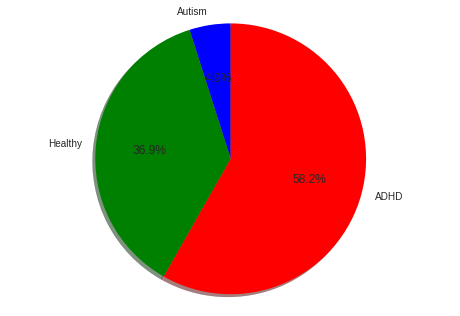

In [13]:
from collections import Counter
import matplotlib.pyplot as plt

c = Counter(np.asarray(clean_dataset_01[['Disease']]).flatten())
keys, sizes = list(zip(*list(c.items())))


labels = ['Autism', 'Healthy', 'ADHD']

keys = np.asarray(keys)
sizes = np.asarray(sizes)
sizes = sizes / np.sum(sizes)

sizes = np.sort(sizes)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors = ['blue', 'green', 'red'], autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## 2. Aggregate with Spectro data

In [14]:
clean_dataset_02 = clean_dataset_01.copy()

### Aggregation

In [15]:
df_spectro_cluster.rename(columns={'id': 'Patient_ID'}, inplace=True)
print("Original lengths: " + str(len(df_spectro_cluster)) + "(spectro)")

# Aggregate with label
df_clean_spectro_cluster = pd.merge(clean_dataset_02['Patient_ID'], df_spectro_cluster, on='Patient_ID')
print("Only clean samples, resulting lengths: " + str(len(df_clean_spectro_cluster)) + "(spectro)")

# Replace NaN values by median
df_clean_spectro_cluster = fill_with_median(df_clean_spectro_cluster)
print("Replace NaN by median, resulting lenghts: " + str(len(df_clean_spectro_cluster)) + "(spectro)")

Original lengths: 1485(spectro)
Only clean samples, resulting lengths: 397(spectro)
Replace NaN by median, resulting lenghts: 397(spectro)


## 3. Split the data into train\test and compute residuals

In [16]:
clean_dataset_03 = clean_dataset_02.copy()

### Build the clean test and train datasets

In [17]:
healthy_patients =  \
clean_dataset_03[clean_dataset_03["Disease"] == 0][['Patient_ID', 'Age']]

In [18]:
train_ratio = 0.5
train_size = int(len(healthy_patients)*train_ratio)

In [19]:
train_healthy_indices = np.random.choice(len(healthy_patients), train_size, replace=False)
train_healthy_patients = healthy_patients.iloc[train_healthy_indices,:]

In [20]:
clean_test_dataset = clean_dataset_03.copy()

for train_patient_id in train_healthy_patients['Patient_ID']:
    clean_test_dataset = clean_test_dataset[clean_test_dataset.Patient_ID != train_patient_id]
    
clean_test_dataset = pd.merge(clean_test_dataset, df_clean_spectro_cluster, on='Patient_ID')

In [21]:
clean_train_dataset = pd.merge(train_healthy_patients, df_clean_spectro_cluster, on='Patient_ID')

### Build X_train,  y_train, X_test and y_test

In [22]:
X_train = clean_train_dataset.drop(['Age', 'Patient_ID'], axis=1)
y_train = clean_train_dataset[['Age']]

In [23]:
X_test = clean_test_dataset.drop(['Age', 'Patient_ID', 'SRS_Total', 'SWAN_Avg', 'Disease'], axis=1)
y_test = clean_test_dataset[['Age']]

### Train Random Forest

In [24]:
# Outlier detection
forest = IsolationForest()
forest.fit(X_train)

# Outlier indices for training
outliers_training = forest.predict(X_train)
outliers_training_indices = np.argwhere(outliers_training == 1).flatten()

# Drop signal outliers in training data
X_train = X_train[outliers_training == 1]
y_train = y_train[outliers_training == 1]

In [25]:
# Feature Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [26]:
# Best parameters for Random Forest: 
# {'max_depth': 30, 'max_leaf_nodes': 100, 'min_samples_split': 2, 'n_estimators': 1000}

# Create random forest object
rdf = RandomForestRegressor(max_depth=30, max_leaf_nodes=100, min_samples_split=2, n_estimators=1000) 
rdf.fit(X_train, y_train) 

<ipython-input-26-ec4db0903f79>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rdf.fit(X_train, y_train)


RandomForestRegressor(max_depth=30, max_leaf_nodes=100, n_estimators=1000)

### Test Random Forest

In [27]:
clean_test_dataset_healthy = \
    clean_test_dataset[clean_test_dataset["Disease"] == 0]
predictions_healthy = \
rdf.predict(clean_test_dataset_healthy.drop(['Age', 'Patient_ID', 'SRS_Total', 'SWAN_Avg', 'Disease'], axis=1))

In [28]:
predictions = rdf.predict(X_test)

### Construct final dataset with residuals

In [29]:
residuals = clean_test_dataset['Age'] - predictions

In [30]:
residuals_healthy = clean_test_dataset_healthy['Age'] - predictions_healthy

In [31]:
normed_residuals = residuals / np.sqrt(np.var(residuals_healthy))

In [32]:
clean_dataset_03 = clean_test_dataset.copy()[['Patient_ID', 'Age', 'Disease', 'SRS_Total', 'SWAN_Avg']]
clean_dataset_03['Age_residual'] = normed_residuals

In [33]:
# Shuffle and output dataset
clean_dataset_03 = clean_dataset_03.sample(frac=1).reset_index(drop=True)
clean_dataset_03.head(5)

,Patient_ID,Age,Disease,SRS_Total,SWAN_Avg,Age_residual
0,NDARKG460MWV,7.174309,1,106.0,2.388888,-0.109237
1,NDARFW292PBD,12.480835,0,6.0,-2.722222,0.159283
2,NDARRY280KNW,7.949691,0,37.0,0.000000,-0.409497
3,NDARFY009MNL,10.736710,1,32.0,0.833333,0.361274
4,NDARXV445NYZ,7.571868,0,41.0,0.500000,0.092940


### Distribution of samples

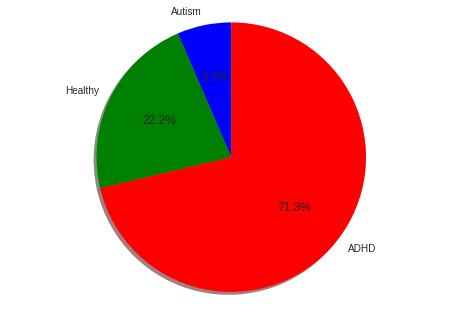

In [34]:
from collections import Counter
import matplotlib.pyplot as plt

c = Counter(np.asarray(clean_dataset_03[['Disease']]).flatten())
keys, sizes = list(zip(*list(c.items())))

labels = ['Autism', 'Healthy', 'ADHD']

keys = np.asarray(keys)
sizes = np.asarray(sizes)
sizes = sizes / np.sum(sizes)

sizes = np.sort(sizes)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors = ['blue', 'green', 'red'], autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [35]:
healthy_sample_size = len(clean_dataset_03[clean_dataset_03["Disease"] == 0][['Patient_ID']])
adhd_sample_size = len(clean_dataset_03[clean_dataset_03["Disease"] == 1][['Patient_ID']])
autism_sample_size = len(clean_dataset_03[clean_dataset_03["Disease"] == 2][['Patient_ID']])

print("Sample size for Healthy poeple: " + str(healthy_sample_size))
print("Sample size for ADHD poeple: " + str(adhd_sample_size))
print("Sample size for Autism poeple: " + str(autism_sample_size))

Sample size for Healthy poeple: 72
Sample size for ADHD poeple: 231
Sample size for Autism poeple: 21


## 4. Visualize the age distribution for each cohort and test potential difference

In [36]:
clean_dataset_04 = clean_dataset_03.copy()

### Distribution of age for each cohort

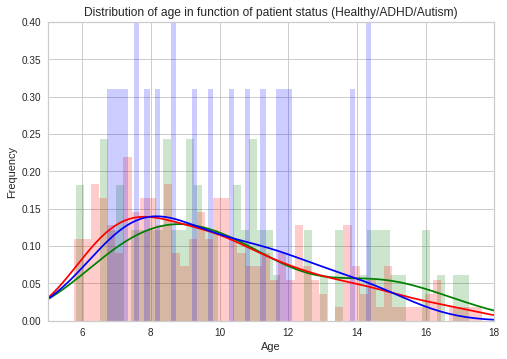

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

age_healthy = np.asarray(clean_dataset_04[clean_dataset_04["Disease"] == 0][['Age']]).flatten()
age_adhd = np.asarray(clean_dataset_04[clean_dataset_04["Disease"] == 1][['Age']]).flatten()
age_autism = np.asarray(clean_dataset_04[clean_dataset_04["Disease"] == 2][['Age']]).flatten()

plt.hist(age_healthy, 50, facecolor='green', density=True, alpha=0.2)
plt.hist(age_adhd, 50, facecolor='red', density=True, alpha=0.2)
plt.hist(age_autism, 50, facecolor='blue', density=True, alpha=0.2)

sns.distplot(age_healthy, hist = False, color = 'green')
sns.distplot(age_adhd, hist = False, color = 'red')
sns.distplot(age_autism, hist = False, color = 'blue')

plt.xlim((5, 18)) 
plt.ylim((0, 0.4))

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of age in function of patient status (Healthy/ADHD/Autism)')

plt.show()


### Test for potential difference in distribution

For the test to be effective, it requires at least 20 observations in each data sample.

In [38]:
healthy_sample_size = len(clean_dataset_04[clean_dataset_04["Disease"] == 0][['Patient_ID']])
adhd_sample_size = len(clean_dataset_04[clean_dataset_04["Disease"] == 1][['Patient_ID']])
autism_sample_size = len(clean_dataset_04[clean_dataset_04["Disease"] == 2][['Patient_ID']])

print("Sample size for Healthy poeple: " + str(healthy_sample_size))
print("Sample size for ADHD poeple: " + str(adhd_sample_size))
print("Sample size for Autism poeple: " + str(autism_sample_size))

Sample size for Healthy poeple: 72
Sample size for ADHD poeple: 231
Sample size for Autism poeple: 21


### Wilcoxon Test for age distribution between (Healthy, ADHD) and (Healthy, Autism)

In [39]:
from scipy.stats import mannwhitneyu

age_healthy = np.asarray(clean_dataset_04[clean_dataset_04["Disease"] == 0][['Age']]).flatten()
age_adhd = np.asarray(clean_dataset_04[clean_dataset_04["Disease"] == 1][['Age']]).flatten()
age_autism = np.asarray(clean_dataset_04[clean_dataset_04["Disease"] == 2][['Age']]).flatten()

age_stat_healthy_adhd, age_p_healthy_adhd = mannwhitneyu(age_healthy, age_adhd)
age_stat_healthy_autism, age_p_healthy_autism = mannwhitneyu(age_healthy, age_autism)

In [40]:
def interpret(stat, p):
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

In [41]:
print('----- WILCOXON TEST (Healthy, ADHD) ------')
interpret(age_stat_healthy_adhd, age_p_healthy_adhd)

----- WILCOXON TEST (Healthy, ADHD) ------
Statistics=7441.000, p=0.089
Same distribution (fail to reject H0)


In [42]:
print('----- WILCOXON TEST (Healthy, Autism) ------')
interpret(age_stat_healthy_autism, age_p_healthy_autism)

----- WILCOXON TEST (Healthy, Autism) ------
Statistics=690.000, p=0.274
Same distribution (fail to reject H0)


## 5. Resample the patients to minimize the effect of age on statistical analysis

In [43]:
clean_dataset_05 = clean_dataset_04.copy()

## 6. Visualize the change and test again

In [44]:
clean_dataset_06 = clean_dataset_05.copy()

## 7. Perform statistical testing and conclude

In [45]:
clean_dataset_07 = clean_dataset_06.copy()

### For Task 2: Distribution of residuals for each cohort

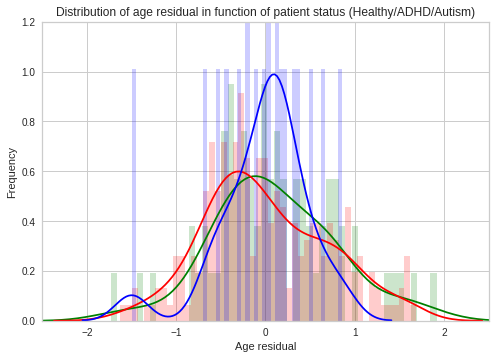

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

age_residual_healthy = np.asarray(clean_dataset_07[clean_dataset_07["Disease"] == 0][['Age_residual']]).flatten()
age_residual_adhd = np.asarray(clean_dataset_07[clean_dataset_07["Disease"] == 1][['Age_residual']]).flatten()
age_residual_autism = np.asarray(clean_dataset_07[clean_dataset_07["Disease"] == 2][['Age_residual']]).flatten()

plt.hist(age_residual_healthy, 50, facecolor='green', density=True, alpha=0.2)
plt.hist(age_residual_adhd, 50, facecolor='red', density=True, alpha=0.2)
plt.hist(age_residual_autism, 50, facecolor='blue', density=True, alpha=0.2)

sns.distplot(age_residual_healthy, hist = False, color = 'green')
sns.distplot(age_residual_adhd, hist = False, color = 'red')
sns.distplot(age_residual_autism, hist = False, color = 'blue')

plt.xlim((-2.5, 2.5)) 
plt.ylim((0, 1.2))

plt.xlabel('Age residual')
plt.ylabel('Frequency')
plt.title('Distribution of age residual in function of patient status (Healthy/ADHD/Autism)')

plt.show()

### For Task 2: Wilcoxon Test for residual distribution between (Healthy, ADHD) and (Healthy, Autism)

In [47]:
from scipy.stats import mannwhitneyu

age_residual_healthy = np.asarray(clean_dataset_07[clean_dataset_07["Disease"] == 0][['Age_residual']]).flatten()
age_residual_adhd = np.asarray(clean_dataset_07[clean_dataset_07["Disease"] == 1][['Age_residual']]).flatten()
age_residual_autism = np.asarray(clean_dataset_07[clean_dataset_07["Disease"] == 2][['Age_residual']]).flatten()

age_residual_stat_healthy_adhd, age_residual_p_healthy_adhd = \
                        mannwhitneyu(age_residual_healthy, age_residual_adhd)
age_residual_stat_healthy_autism, age_residual_p_healthy_autism = \
                        mannwhitneyu(age_residual_healthy, age_residual_autism)

In [48]:
print('----- WILCOXON TEST (Healthy, ADHD) ------')
interpret(age_residual_stat_healthy_adhd, age_residual_p_healthy_adhd)

----- WILCOXON TEST (Healthy, ADHD) ------
Statistics=7534.000, p=0.114
Same distribution (fail to reject H0)


In [49]:
print('----- WILCOXON TEST (Healthy, Autism) ------')
interpret(age_residual_stat_healthy_autism, age_residual_p_healthy_autism)

----- WILCOXON TEST (Healthy, Autism) ------
Statistics=716.000, p=0.358
Same distribution (fail to reject H0)


### Towards Task 3: distribution of the SWAN score and SRS score for each cohort

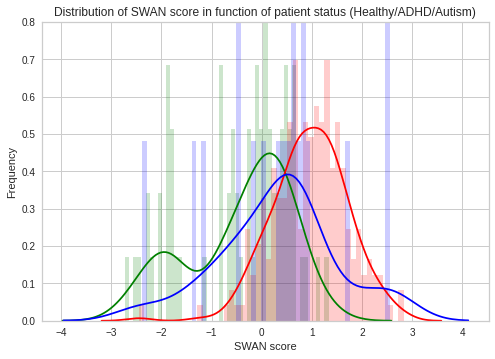

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

swan_healthy = np.asarray(clean_dataset_07[clean_dataset_07["Disease"] == 0][['SWAN_Avg']]).flatten()
swan_adhd = np.asarray(clean_dataset_07[clean_dataset_07["Disease"] == 1][['SWAN_Avg']]).flatten()
swan_autism = np.asarray(clean_dataset_07[clean_dataset_07["Disease"] == 2][['SWAN_Avg']]).flatten()

plt.hist(swan_healthy, 50, facecolor='green', density=True, alpha=0.2)
plt.hist(swan_adhd, 50, facecolor='red', density=True, alpha=0.2)
plt.hist(swan_autism, 50, facecolor='blue', density=True, alpha=0.2)

sns.distplot(swan_healthy, hist = False, color = 'green')
sns.distplot(swan_adhd, hist = False, color = 'red')
sns.distplot(swan_autism, hist = False, color = 'blue')

plt.ylim((0, 0.8))

plt.xlabel('SWAN score')
plt.ylabel('Frequency')
plt.title('Distribution of SWAN score in function of patient status (Healthy/ADHD/Autism)')

plt.show()

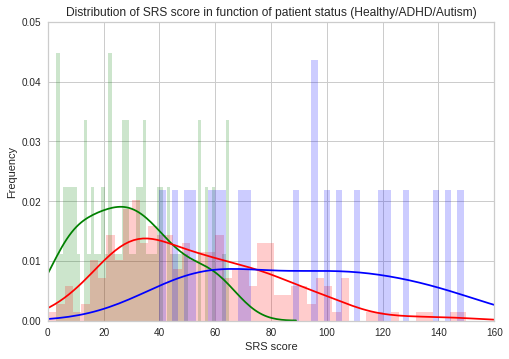

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

swan_healthy = np.asarray(clean_dataset_07[clean_dataset_07["Disease"] == 0][['SRS_Total']]).flatten()
swan_adhd = np.asarray(clean_dataset_07[clean_dataset_07["Disease"] == 1][['SRS_Total']]).flatten()
swan_autism = np.asarray(clean_dataset_07[clean_dataset_07["Disease"] == 2][['SRS_Total']]).flatten()

plt.hist(swan_healthy, 50, facecolor='green', density=True, alpha=0.2)
plt.hist(swan_adhd, 50, facecolor='red', density=True, alpha=0.2)
plt.hist(swan_autism, 50, facecolor='blue', density=True, alpha=0.2)

sns.distplot(swan_healthy, hist = False, color = 'green')
sns.distplot(swan_adhd, hist = False, color = 'red')
sns.distplot(swan_autism, hist = False, color = 'blue')

plt.xlim((0, 160)) 
plt.ylim((0, 0.05))

plt.xlabel('SRS score')
plt.ylabel('Frequency')
plt.title('Distribution of SRS score in function of patient status (Healthy/ADHD/Autism)')

plt.show()

### Towards task 3: T-Test on Age_residual = a_0 + a_1SWAN + a_2SRS

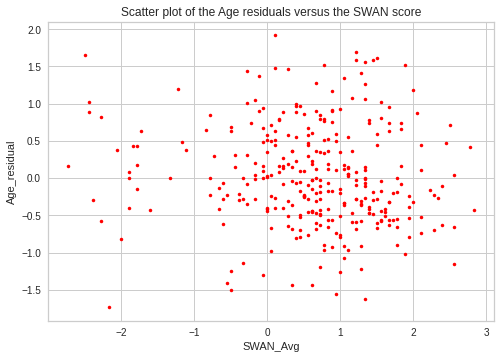

In [52]:
plt.plot(clean_dataset_07["SWAN_Avg"], clean_dataset_07["Age_residual"], '.', color='red');
plt.xlabel("SWAN_Avg")
plt.ylabel("Age_residual")
plt.title("Scatter plot of the Age residuals versus the SWAN score");

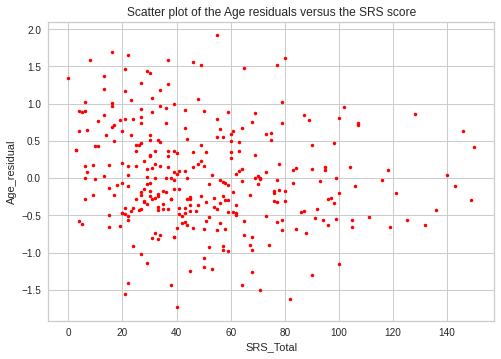

In [53]:
plt.plot(clean_dataset_07["SRS_Total"], clean_dataset_07["Age_residual"], '.', color='red');
plt.xlabel("SRS_Total")
plt.ylabel("Age_residual")
plt.title("Scatter plot of the Age residuals versus the SRS score");

In [54]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats

X = clean_dataset_07[["SRS_Total", "SWAN_Avg"]]
y = clean_dataset_07[["Age_residual"]]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           Age_residual   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     4.681
Date:                Wed, 18 Nov 2020   Prob (F-statistic):            0.00991
Time:                        18:16:05   Log-Likelihood:                -329.19
No. Observations:                 324   AIC:                             664.4
Df Residuals:                     321   BIC:                             675.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0240      0.037      0.644      0.5

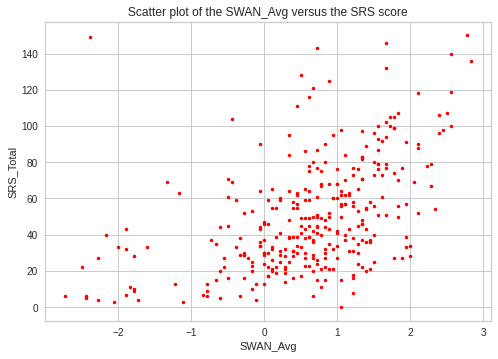

In [55]:
plt.plot(clean_dataset_07["SWAN_Avg"], clean_dataset_07["SRS_Total"], '.', color='red');
plt.xlabel("SWAN_Avg")
plt.ylabel("SRS_Total")
plt.title("Scatter plot of the SWAN_Avg versus the SRS score");

In [56]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats

X = clean_dataset_07[["SRS_Total"]]
y = clean_dataset_07[["SWAN_Avg"]]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               SWAN_Avg   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     106.0
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           1.12e-21
Time:                        18:16:05   Log-Likelihood:                -421.56
No. Observations:                 324   AIC:                             847.1
Df Residuals:                     322   BIC:                             854.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6123      0.050     12.361      0.0

### Conclusion

In [57]:
# TODO